10
Chosen model:  res_net
Building a new model
Epoch 1/50
391/391 [==============================] - 38s 97ms/step - loss: 1.5354 - accuracy: 0.4546 - val_loss: 1.6801 - val_accuracy: 0.4660
Epoch 2/50
391/391 [==============================] - 37s 94ms/step - loss: 1.0389 - accuracy: 0.6355 - val_loss: 2.6079 - val_accuracy: 0.4095
Epoch 3/50
391/391 [==============================] - 37s 95ms/step - loss: 0.8301 - accuracy: 0.7138 - val_loss: 1.2318 - val_accuracy: 0.6454
Epoch 4/50
391/391 [==============================] - 37s 94ms/step - loss: 0.6515 - accuracy: 0.7765 - val_loss: 0.7563 - val_accuracy: 0.7552
Epoch 5/50
391/391 [==============================] - 37s 94ms/step - loss: 0.5474 - accuracy: 0.8150 - val_loss: 0.9034 - val_accuracy: 0.7598
Epoch 6/50
391/391 [==============================] - 37s 94ms/step - loss: 0.4732 - accuracy: 0.8386 - val_loss: 0.6297 - val_accuracy: 0.7936
Epoch 7/50
391/391 [==============================] - 37s 94ms/step - loss: 0.4085 - accu

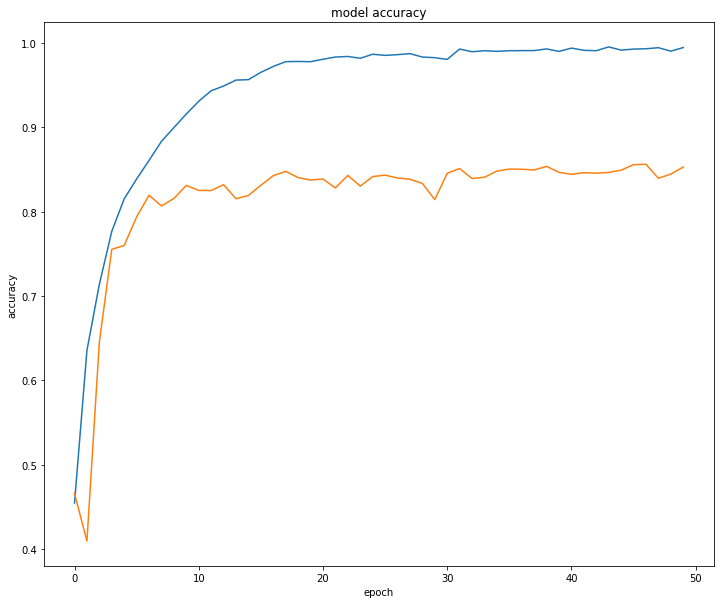

In [19]:
def train_model(
    database: str,
    input_shape: list,
    model_name: str,
    is_restore: bool = False,
    is_dynamic: bool = True,
    is_plot: bool = True,
    learning_rate: float = 0.001,
    dropout=0.3,
    loss=Losses.CategoricalCrossentropy.value,
    optimizer=Optimizers.Adam.value,
):
    (ds_train, ds_test), ds_info = load_tf_dataset(database)
    n_classes = ds_info.features['label'].num_classes
    print(n_classes)

    save_prefix = '{}_{}_{}_{}_{}_'.format(database, model_name, is_dynamic, dropout, learning_rate)

    with tf.device(device_name):
        model = CNNModel(
            n_classes=n_classes,
            is_restore=is_restore,
            model_name=model_name,
            input_shape=input_shape,
            is_dynamic=is_dynamic,
            save_dir=MODEL_SAVE_FIR,
            save_prefix=save_prefix,
            learning_rate=learning_rate,
            dropout=dropout,
            loss=loss,
            optimizer=optimizer,
        )
        model.fit(
            ds_train,
            n_epochs=50,
            validation_data=ds_test,
            initial_epoch=0,
            verbose=1,
        )

        score = model.model.evaluate(ds_test, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])

        history = model.history
        dropout_parameters = model.parameters

    now = prettify_datetime(datetime.now())
    with open(HISTORY_SAVE_FIR + '{}_history_{}.json'.format(save_prefix, now), 'w') as histories_file:
        json.dump(history, histories_file, indent=4)
    with open(HISTORY_SAVE_FIR + '{}_parameters_{}.json'.format(save_prefix, now), 'w') as parameters_file:
        json.dump(dropout_parameters, parameters_file, indent=4)

    if is_plot:
        plt.figure(figsize=(12, 10))

        # summarize history for accuracy
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.plot(history['accuracy'])
        plt.plot(history['val_accuracy'])

        plt.show()


train_model(
    Databases.Cifar10.value,
    [32, 32, 3],
    Models.ResNet.value,
    is_restore=False,
    is_dynamic=False,
    dropout=None,
    is_plot=True,
)
# for is_dynamic in [False, True]:
#     for dropout in [0.1, 0.2, 0.3, 0.5]:
#         train_model(
#             Databases.Cifar10.value,
#             [32, 32, 3],
#             Models.ResNet.value,
#             is_restore=False,
#             is_dynamic=is_dynamic,
#             dropout=dropout,
#             is_plot=True,
#         )


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
class CNNModel:
    def __init__(
        self,
        model_name: str,
        input_shape: list,
        n_classes: int,
        loss: str or object,
        optimizer: str or object,
        learning_rate: float,
        dropout: float,
        save_prefix: str,
        save_dir: str,
        is_restore: bool = False,
        is_dynamic: bool = False,
    ):
        self.model = None
        self.parameters = []
        self.history = None

        self.model_name = model_name
        self.input_shape = input_shape
        self.n_classes = n_classes
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.dropout = dropout
        self.loss = loss

        self.save_prefix = save_prefix
        self.is_restore = is_restore
        self.is_dynamic = is_dynamic
        self.save_dir = save_dir

        self.callbacks = [
            # keras.callbacks.ModelCheckpoint(
            #     filepath=self.save_dir + '_{epoch:04d}-{val_loss:.2f}.hdf5',
            #     period=250,
            # ),
            keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=100),
        ]

        print("Chosen model: ", self.model_name)
        self.build_or_restore_model()

    def build_or_restore_model(self):
        if self.is_restore:
            checkpoints = [
                os.path.join(self.save_dir, name)
                for name in os.listdir(self.save_dir)
                if self.save_prefix in name
            ]

            if checkpoints:
                latest_checkpoint = max(checkpoints, key=os.path.getctime)

                print('Restoring from', latest_checkpoint)
                self.model = keras.models.load_model(
                    latest_checkpoint,
                    custom_objects={
                        DynamicDropout.__name__: DynamicDropout,
                    },
                )
        else:
            print('Building a new model')
            self.build_model()

    def build_model(self):
        dropout = None
        if self.dropout:
            dropout = DynamicDropout(
                self.dropout,
                is_dynamic=self.is_dynamic,
            )

        if self.model_name == Models.ResNet.value:
            self.model = ResNet.build(dropout, self.input_shape, self.n_classes)

        optimizer = self.optimizer if isinstance(self.optimizer, str) else self.optimizer(self.learning_rate)
        self.model.compile(
            loss=self.loss,
            optimizer=optimizer,
            metrics=['accuracy'],
        )

    def fit(
        self,
        ds_train,
        n_epochs,
        validation_data=None,
        initial_epoch=0,
        verbose=1,
        save=True,
    ):
        if self.model:
            dropout_callback = DropoutParameterCallback(self.model)
            self.history = self.model.fit(
                ds_train,
                epochs=n_epochs,
                validation_data=validation_data,
                initial_epoch=initial_epoch,
                callbacks=self.callbacks + [dropout_callback],
                verbose=verbose,
            ).history
            self.parameters = dropout_callback.parameters[:]

            if save:
                self.model.save(
                    self.save_dir + self.save_prefix + f'_{n_epochs}_{prettify_datetime(datetime.now())}.hdf5',
                )


In [0]:
class ResNet:
    @staticmethod
    def build(dropout, input_shape: list, n_classes: int) -> Model:
        inputs = Input(shape=input_shape)
        num_filters = 64

        t = BatchNormalization()(inputs)
        t = Conv2D(
            kernel_size=3,
            strides=1,
            filters=num_filters,
            padding='same',
        )(t)
        t = ResNet.__relu_with_normalization(t)

        num_blocks_list = [2, 5, 5, 2]
        for i in range(len(num_blocks_list)):
            num_blocks = num_blocks_list[i]
            for j in range(num_blocks):
                t = ResNet.__residual_block(t, down_sample=(j == 0 and i != 0), filters=num_filters)
                if dropout:
                    t = dropout(t)
            num_filters *= 2

        t = AveragePooling2D(4)(t)
        t = Flatten()(t)
        outputs = Dense(n_classes, activation='softmax')(t)

        return Model(inputs, outputs)

    @staticmethod
    def __relu_with_normalization(inputs: Tensor) -> Tensor:
        relu = ReLU()(inputs)
        bn = BatchNormalization()(relu)

        return bn

    @staticmethod
    def __residual_block(x: Tensor, down_sample: bool, filters: int, kernel_size: int = 3) -> Tensor:
        y = Conv2D(
            kernel_size=kernel_size,
            strides=(1 if not down_sample else 2),
            filters=filters,
            padding='same',
        )(x)
        y = ResNet.__relu_with_normalization(y)
        y = Conv2D(
            kernel_size=kernel_size,
            strides=1,
            filters=filters,
            padding='same',
        )(y)

        if down_sample:
            x = Conv2D(
                kernel_size=1,
                strides=2,
                filters=filters,
                padding='same',
            )(x)
        out = Add()([x, y])
        out = ResNet.__relu_with_normalization(out)

        return out


class DynamicDropout(Dropout):
    def __init__(self, rate=0.5, *args, is_dynamic=True, **kwargs):
        super(DynamicDropout, self).__init__(rate, *args, **kwargs)

        if is_dynamic:
            self.rate = K.variable(self.rate, name='rate')
            self.rate_value = rate

        self.is_dynamic = is_dynamic

    def set_dropout(self, rate):
        K.set_value(self.rate, rate)
        self.rate_value = rate

    def call(self, inputs, training=None):
        if not self.is_dynamic:
            return super(DynamicDropout, self).call(inputs, training)

        if 0. < self.rate_value < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(
                    inputs,
                    self.rate,
                    noise_shape,
                    seed=self.seed,
                )

            return K.in_train_phase(
                dropped_inputs,
                inputs,
                training=training,
            )
        return inputs

    def get_config(self):
        config = super(DynamicDropout, self).get_config()
        if self.is_dynamic:
            config['rate'] = K.get_value(self.rate)

        return config


class DropoutParameterCallback(keras.callbacks.Callback):
    def __init__(self, model):
        self.model = model
        self.parameters = []
        super(DropoutParameterCallback, self).__init__()

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            print(
                'The average loss for epoch {} is {:7.2f}'.format(
                  epoch,
                  logs['loss'],
                ),
            )
            for index, layer in enumerate(self.model.layers):
                if isinstance(layer, DynamicDropout):
                    rate = layer.rate
                    rate = float(K.get_value(rate))
                    self.parameters.append(rate)
                    break


In [0]:
def prettify_datetime(time: datetime) -> str:
    return time.strftime('%m.%d.%Y_%H:%M:%S')


def resize_img(image, label, size):
    return tf.image.resize(image, size), label


def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label


def categorize_label(image, label, n_classes):
    label = tf.one_hot(tf.cast(label, tf.int32), n_classes)
    label = tf.cast(label, tf.float32)
    return image, label


def load_tf_dataset(tf_dataset_name: str, img_size: list = None):
    (ds_train, ds_test), ds_info = tfds.load(
        tf_dataset_name,
        split=['train', 'test'],
        with_info=True,
        shuffle_files=True,
        as_supervised=True,
    )
    n_classes = ds_info.features['label'].num_classes
    categorize = partial(categorize_label, n_classes=n_classes)

    # train
    ds_train = ds_train.map(
        normalize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )

    ds_train = ds_train.map(
        categorize,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
    ds_train = ds_train.batch(128)
    ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

    # test
    ds_test = ds_test.map(
        normalize_img,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    ds_test = ds_test.map(
        categorize,
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    ds_test = ds_test.batch(128)
    ds_test = ds_test.cache()
    ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)

    if img_size:
        resize_image = partial(resize_img, size=img_size[:2])
        ds_train = ds_train.map(
            resize_image,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
        ds_test = ds_test.map(
            resize_image,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )

    return (ds_train, ds_test), ds_info



In [0]:
import os
import json
from enum import Enum
from datetime import datetime
from functools import partial
from matplotlib import pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import \
    Input, \
    AveragePooling2D, \
    Dense, \
    Conv2D, \
    Flatten, \
    ReLU, \
    BatchNormalization, \
    Add, \
    Dropout
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow import Tensor


In [0]:
class Models(Enum):
    VGG16 = 'vgg16'
    ResNet = 'res_net'


class Databases(Enum):
    Cifar10 = 'cifar10'


class Optimizers(Enum):
    Adam = Adam


class Losses(Enum):
    SparseCategoricalCrossentropy = 'sparse_categorical_crossentropy'
    CategoricalCrossentropy = 'categorical_crossentropy'


MODEL_SAVE_FIR = '/content/drive/My Drive/Colab Notebooks/models/'
HISTORY_SAVE_FIR = '/content/drive/My Drive/Colab Notebooks/histories/'


device_name = tf.test.gpu_device_name()
